author: xh895
date: Nov 10th, 2016

In [125]:
#import packages
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans 
import matplotlib.pylab as plt
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'f', 'mean', 'std', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [126]:
#load data
puidata = os.getenv('PUIDATA')

data = np.load(puidata + '/MTA_Fare.npy')
data = data.astype(float)

# setting value -1 to NaN
data[data == -1] = np.nan
print data.shape

(600, 23, 194)


In [127]:
# Task 1
data1 = pd.DataFrame(data.reshape(600*23,194))

(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

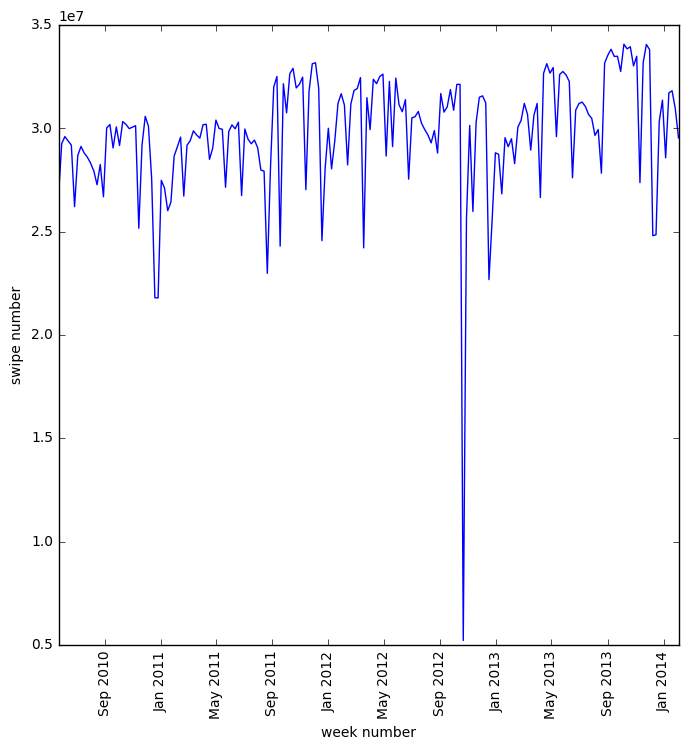

In [128]:
# swipe_by_week gives the total swipe number for each week

swipe_by_week = pd.DataFrame(np.nansum(data1, axis = 0))
week = pd.date_range(start = '05/21/2010', periods = 194, freq = 'W')
swipe_by_week.index = week

plt.figure(figsize = (8,8))
plt.plot(swipe_by_week)
plt.xlabel('week number')
plt.ylabel('swipe number')
plt.xticks(rotation = 90)

In [129]:
# define threshold range by mean +- 3 * standard deviation
std = swipe_by_week.std(axis = 0)
mean = swipe_by_week.mean(axis = 0)
thredshold = [mean - 3*std, mean + 3*std]

In [130]:
# locate the drop that lies outside of the thredshold
swipe_by_week.loc[(swipe_by_week[0] < thredshold[0][0])]

,0
2012-10-21,5218686.0


In [131]:
# Task2
#sum_by_card_type gives the swipe number for each week at each station.
sum_by_station = pd.DataFrame(np.nansum(data, axis = 0), columns=week).T
sum_by_station.head(3)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
2010-05-23,11494615.0,530524.0,47801.0,186551.0,46808.0,3697443.0,8551937.0,10063.0,333197.0,512032.0,...,123134.0,790110.0,59809.0,28221.0,0.0,124693.0,21060.0,6128.0,358.0,0.0
2010-05-30,12526859.0,583533.0,51486.0,199229.0,64353.0,3981808.0,9486394.0,11847.0,282755.0,578023.0,...,151948.0,908068.0,69209.0,32333.0,0.0,121713.0,21670.0,6120.0,474.0,0.0
2010-06-06,12766627.0,586194.0,51636.0,199668.0,56994.0,4033030.0,9476538.0,12277.0,302028.0,615537.0,...,151538.0,914124.0,69574.0,32618.0,0.0,122181.0,21433.0,6490.0,465.0,0.0


In [132]:
# take the rolling mean of 10 data in sum_by_card_type dataframe.
rolling_mean = pd.rolling_mean(sum_by_station, 10).dropna()

# store the first 10 and last 10 week data in a new dataframe.
first_last = rolling_mean.iloc[[0,-1],:].T

first_last.columns = ['0', '-1']
first_last['ratio'] = (first_last['-1'] - first_last['0']) / first_last['-1']


ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
first_last.index = ridetype

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app


In [133]:
down = first_last[first_last.ratio < 0].index
up = first_last[first_last.ratio > 0].index
print 'card types of downward trend: \n'
print down.values
print 'card types of upward trend: \n' 
print up.values

card types of downward trend: 

['2t' 'ada' 'afas' 'exp' 'ez' 'ff' 'month' 'rfm' 'umlim']
card types of upward trend: 

['10t' '14d' '1d' '30d' '7d' 'mc' 'mr' 'rr' 'sen' 'spec' 'tcmc' 't' 'xbus'
 'stud']


In [134]:
# task3
# sum_by_cardtype gives the swipe for each station at every week

sum_by_cardtype = pd.DataFrame(np.nansum(data, axis = 1), columns = week)

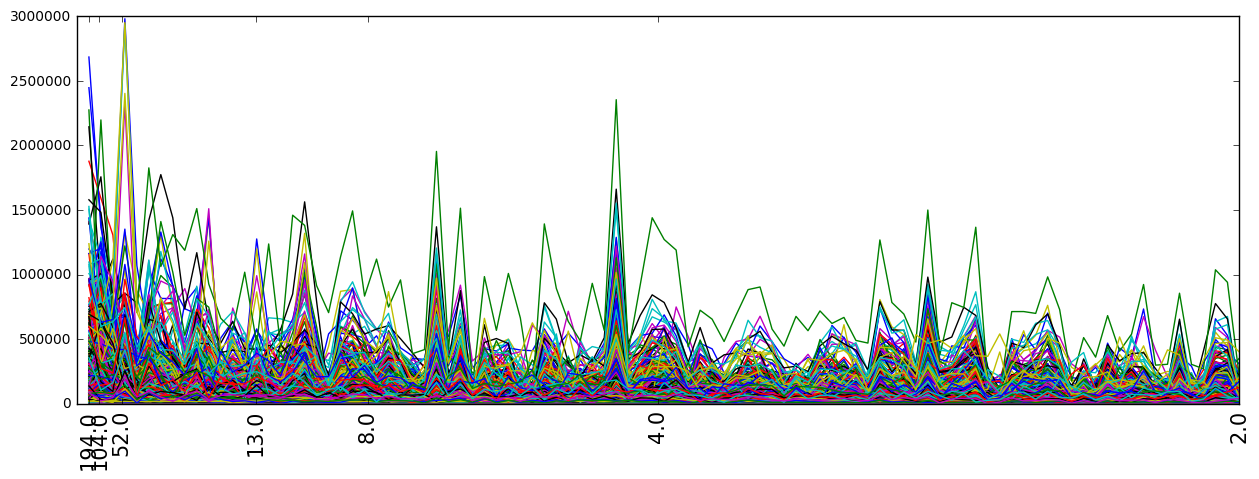

In [135]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)

f_t = {}
# create a dictionary for plotting
yearly = pd.DataFrame()
# create a void dataframe for future use

for i in range(0,600):
    f_t[i] = np.abs(np.fft.rfft(sum_by_cardtype.iloc[i,:]))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], f_t[i][1:], '-', ms=20)
    yearly = pd.concat([yearly, pd.DataFrame(f_t[i])], axis = 1)  
ax.set_xticks([1./194,1./104,1./52,1./13,1./8,0.25,0.5])
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], rotation=90, fontsize=15)
plt.show()

In [136]:
# identify the most power in the dataframe
yearly.columns = range(0,600)
max_within_fft = yearly.iloc[1:,:].apply(max,axis=1)
print 'fft index contains the most power is:'
print max_within_fft.sort_values(ascending=False).head(1)

fft index contains the most power is:
4    2.980161e+06
dtype: float64


In [137]:
#The four stations showing the most prominent periodic trend/
# on annual period
top4 = yearly.ix[4].sort_values(ascending=False).head(4) #head 4 to get top 4
top4

0      2.980161e+06
194    2.950389e+06
150    2.931896e+06
327    2.402219e+06
Name: 4, dtype: float64

In [138]:
# extra credit
# extract data
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1] * data.shape[0]).T
tots = tots[tots.std(1)>0]

In [139]:
# clustering
km = KMeans(n_clusters=10)
vals = ((tots.T - tots.mean(1))/tots.std(1))

valsfit = km.fit(vals)
label = valsfit.labels_

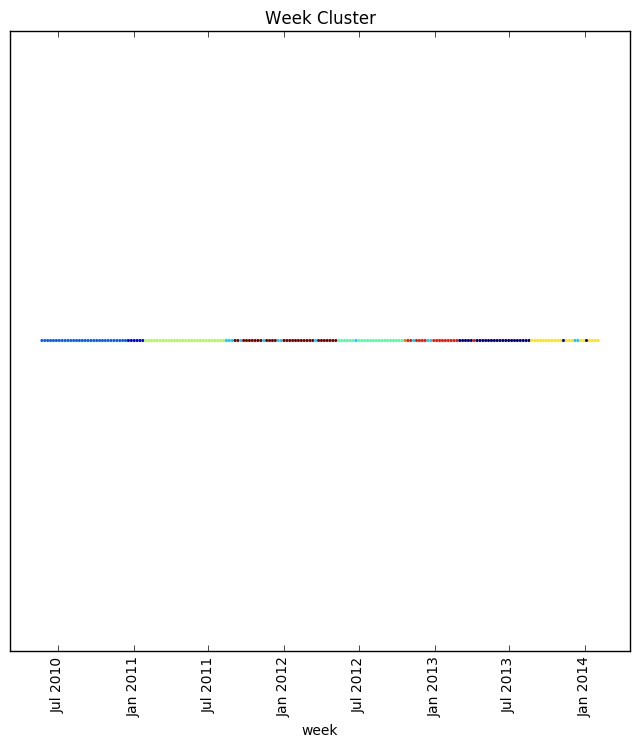

In [140]:
# plot the cluster result, same color indicated the same cluter group.
y = np.zeros(len(week))

plt.figure(figsize = (8,8))
plt.scatter(week, y , c = label, linewidth = 0, s = 5)
plt.yticks([])
plt.xticks(rotation = 90)
ylim(-.0001,.0001)
plt.title('Week Cluster')
plt.xlabel('week')